In [29]:
import pandas as pd
import numpy as np

# data 시각화
import matplotlib
import matplotlib.pyplot as plt

# Korean pont
matplotlib.rc('font',family = 'NanumGothicCoding')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
df_raw = pd.read_csv('./data/HMEQ.csv')
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [7]:
df_raw.isnull().sum(axis = 0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

## 결측치에 대해서 비값에 대채

In [9]:
df_raw['JOB'].fillna('Other', inplace = True)
df_raw.fillna(df_raw.mean(), inplace = True)

In [35]:
df_raw.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

## 데이터 분할

In [10]:
df_train, df_test = train_test_split(df_raw,
                                    test_size = 0.3,
                                    random_state = 1234)

print('train data size : {}'.format(df_train.shape))
print('test data size : {}'.format(df_test.shape))

train data size : (2623, 13)
test data size : (1125, 13)


In [13]:
log_model = Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ + DEROG +
DELINQ + CLAGE + NINQ + CLNO + DEBTINC""",df_train)

log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Fri, 03 May 2019   Pseudo R-squ.:                  0.2257
Time:                        11:51:40   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
                                        LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

>  설명력 : 0.2257로 낮고, 유의수준 0.05에서 유의한 회귀계수를 알 수 있다.

In [20]:
y_pred = log_result.predict(df_test)
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head()

1721    0
822     0
1686    0
789     0
165     0
dtype: int64

In [23]:
print('Accuracy : {0:.3f} \n'.format(accuracy_score(df_test['BAD'], y_pred_class)))
print('Confusion Matrix : \n {}'.format(confusion_matrix(df_test['BAD'], y_pred_class)))

Accuracy : 0.924 

Confusion Matrix : 
 [[1017    4]
 [  81   23]]


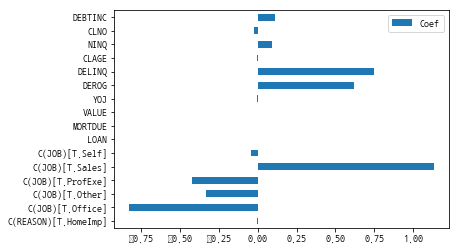

In [24]:
df_logistic_coef = pd.DataFrame({'Coef':log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = 'Coef')

In [27]:
df_char = df_raw.select_dtypes(include = 'object')
df_numeric = df_raw.select_dtypes(exclude = 'object')

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled, df_char],axis=1)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,3.140664,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,3.140664,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,-0.318404,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,3.140664,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,-0.318404,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


## 결론 도출, 표준화 회귀 계수

In [30]:
df_scaled['BAD'] = np.where(df_scaled['BAD']>0,1,0)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


> Bad 데이터를 0과 1로 변환, np.where(조건, 조건만족하는 경우, 아닌경우)

## 데이터 분할

In [31]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled, test_size = 0.3, random_state = 1234)

In [34]:
# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model = Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ + DEROG +
DELINQ + CLAGE + NINQ + CLNO + DEBTINC""",df_scaled_train)

#결합
scaled_log_result = scaled_log_model.fit()

print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Fri, 03 May 2019   Pseudo R-squ.:                  0.2257
Time:                        15:34:33   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
                                        LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.4815      0.205    -12.111      0.000      -2.883      -2.080

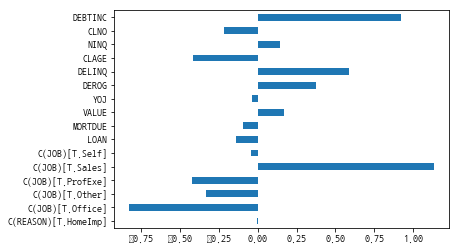

In [33]:
df_logistic_coef = pd.DataFrame({'Coef':scaled_log_result.params.values[1:]}, index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y = 'Coef', legend = False)

# 로지스틱 회귀분석 - 실습